# IEEE-CIS Fraud Detection
Can you detect fraud from customer transactions?

* In this problem, we have the to train a model to spot fraudulent activity using feature-rich data based on real-world e-commerce transactions.

# Data Description

In this problem we are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.
Categorical Features - Transaction

    ProductCD
    card1 - card6
    addr1, addr2
    P_emaildomain
    R_emaildomain
    M1 - M9

Categorical Features - Identity

    DeviceType
    DeviceInfo
    id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).
Files

    train_{transaction, identity}.csv - the training set
    test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
    sample_submission.csv - a sample submission file in the correct format


# Various columns present in each Table

### Transaction Table

> Transaction Table

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

#### Categorical Features:
* ProductCD
* card1 - card6
* addr1, addr2
* Pemaildomain Remaildomain
* M1 - M9

### Identity Table

> Identity Table 

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

#### Categorical Features:
* DeviceType
* DeviceInfo
* id12 - id38

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from tqdm import tqdm


from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

# 1.1 Reading Data

This function as it's name suggests is used for reducing the memory used for storing a dataframe while it's is use.
So while the dataframe is loaded in the memory it's is stored in a such a way that it uses less memory.

In [3]:
# reduce memory ussage kaggle      ----------------->     https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [4]:
%%time
# reading data from the csv files those are provided to us
# we have different files for train and test data and also we have two different fiels
# one is trasanction table and the other one is identity table


####################################### transaction ################################### 
train_transact = import_data('train_transaction.csv')
test_transact  = import_data('test_transaction.csv')

####################################### identity ######################################
train_ident = import_data('train_identity.csv')
test_ident  = import_data('test_identity.csv')


Memory usage of dataframe is 1775.15 MB --> 916.30 MB (Decreased by 48.4%)
Memory usage of dataframe is 1519.24 MB --> 785.71 MB (Decreased by 48.3%)
Memory usage of dataframe is 45.12 MB --> 31.91 MB (Decreased by 29.3%)
Memory usage of dataframe is 44.39 MB --> 31.40 MB (Decreased by 29.3%)
Wall time: 7min 1s


Above we can see that for storing transaction data almost 50% less memory is used using our reduce_mem_usage function, which is really helpful to conserve your RAM for later use.

In [5]:
print('Number of datapoints in train transaction :',train_transact.shape)
print('Number of datapoints in test transaction  :',test_transact.shape)
print('Number of datapoints in train identity    :',train_ident.shape)
print('Number of datapoints in test identity     :',test_ident.shape)


Number of datapoints in train transaction : (590540, 394)
Number of datapoints in test transaction  : (506691, 393)
Number of datapoints in train identity    : (144233, 41)
Number of datapoints in test identity     : (141907, 41)


In [6]:
train_transact.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
test_transact.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As above we can observe that in train_transact data set we have 394 features where as in test_transact we have 393 features, so we need to find out which column is not present in test and only present in train data set.

In [8]:
# we are trying to find out if there is any feature which is missing in test dataset with respect to train dataset

[col for col in train_transact.columns if col not in test_transact.columns]

['isFraud']

In [9]:
train_ident.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


## Merging both transaction and identity features

In [10]:
train_transact_ident = pd.merge(train_transact, train_ident,how='left',on='TransactionID')
test_transact_ident  = pd.merge(test_transact,  test_ident, how='left',on='TransactionID')

In [11]:
train_transact_ident.shape

(590540, 434)

In [12]:
test_transact_ident.shape

(506691, 433)

### Freeing the space beacuse we no longer needed these as we already merged this data

In [13]:
del train_transact, train_ident, test_transact, test_ident

## Data Analysis

Number of genuine transactions:  569877 , ( 96.50099908558268 %)
Number of Fraud transactions  :  20663 , ( 3.4990009144173126 %)


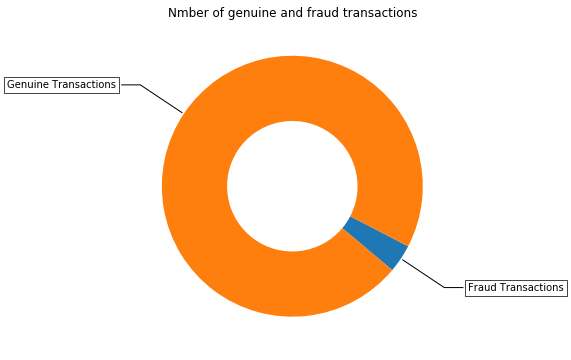

In [14]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = train_transact_ident['isFraud'].value_counts()
print("Number of genuine transactions: ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of Fraud transactions  : ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Fraud Transactions", "Genuine Transactions"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of genuine and fraud transactions")

plt.show()

### One thing we can observe from this visual is our data is highly imbalanced, fraud transactions are extremely low as compared to genuine transactions(which is a good thing in general) which makes the whole data set really imbalanced.

In [24]:
# Not all transactions have corresponding identity information.
#len([c for c in train_trn['TransactionID'] if c not in train_id['TransactionID'].values]) #446307

# Not all fraud transactions have corresponding identity information.
fraud_id = train_transact[train_transact['isFraud'] == 1]['TransactionID']
fraud_id_in_trn = [i for i in fraud_id if i in train_ident['TransactionID'].values]
print(len(fraud_id), len(fraud_id_in_trn))

20663 11318


## Univariat Analysis

### Transaction features

In [12]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='isFraud', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('% of projects aproved state wise')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'isFraud'))
    plt.show()

In [13]:
def univariate_barplots(data, col1, col2='isFraud', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(train_transact_ident.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(train_transact_ident.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg']   = pd.DataFrame(train_transact_ident.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

## Uninvariate Analysis ProductCD

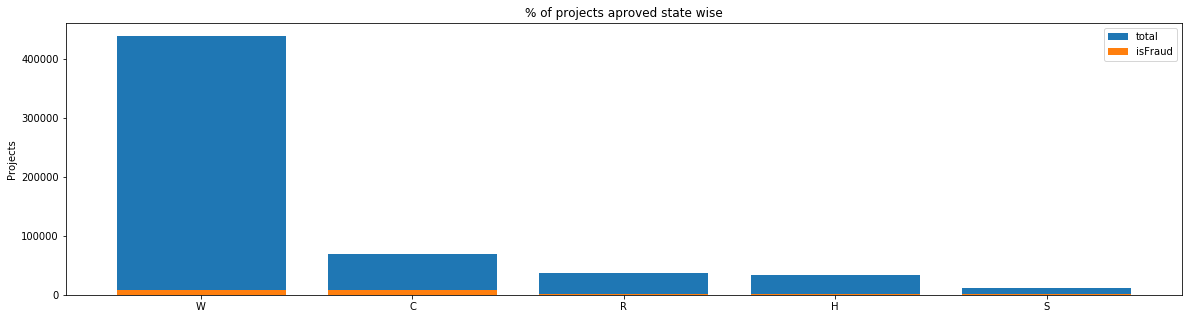

  ProductCD  isFraud   total       Avg
4         W     8969  439670  0.020399
0         C     8008   68519  0.116873
2         R     1426   37699  0.037826
1         H     1574   33024  0.047662
3         S      686   11628  0.058996
  ProductCD  isFraud   total       Avg
4         W     8969  439670  0.020399
0         C     8008   68519  0.116873
2         R     1426   37699  0.037826
1         H     1574   33024  0.047662
3         S      686   11628  0.058996


In [14]:
univariate_barplots(train_transact_ident, 'ProductCD', 'isFraud', False)

## Uninvariate Analysis Card1

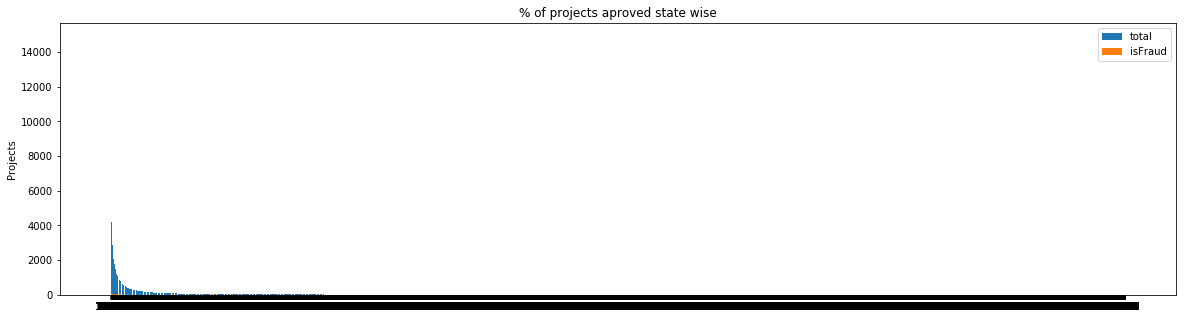

       card1  isFraud  total       Avg
5365    7919      112  14932  0.007501
6615    9500      528  14162  0.037283
11593  15885      444  10361  0.042853
12616  17188      278  10344  0.026875
10950  15066      313   7945  0.039396
       card1  isFraud  total  Avg
7157   10200        0      1  0.0
7151   10191        0      1  0.0
7148   10187        0      1  0.0
7145   10184        0      1  0.0
13552  18396        0      1  0.0


In [37]:
univariate_barplots(train_transact_ident, 'card1', 'isFraud', False)

## Uninvariate Analysis Card2

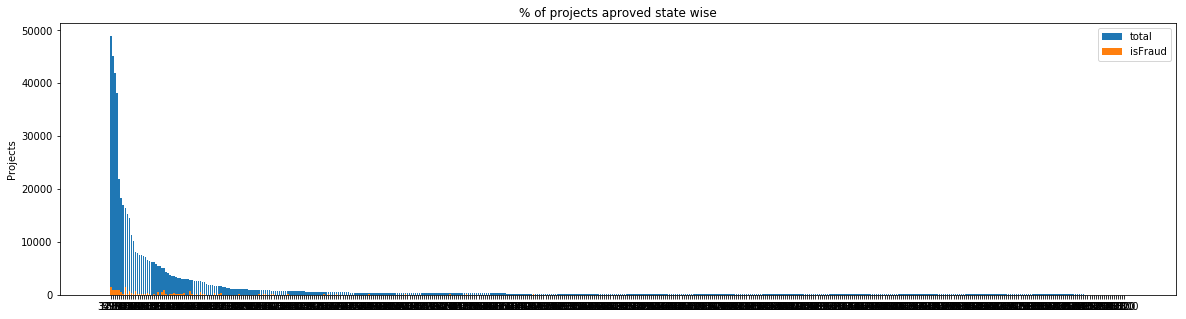

     card2  isFraud  total       Avg
220  321.0     1396  48935  0.028528
10   111.0      978  45191  0.021641
454  555.0      959  41995  0.022836
389  490.0      916  38145  0.024014
482  583.0      899  21803  0.041233
     card2  isFraud  total       Avg
346  447.0        1     39  0.025641
52   153.0        0     38  0.000000
456  557.0        0     37  0.000000
372  473.0        0     18  0.000000
481  582.0        0     14  0.000000


In [38]:
univariate_barplots(train_transact_ident, 'card2', 'isFraud', False)

## Uninvariate Analysis P_emaildomain

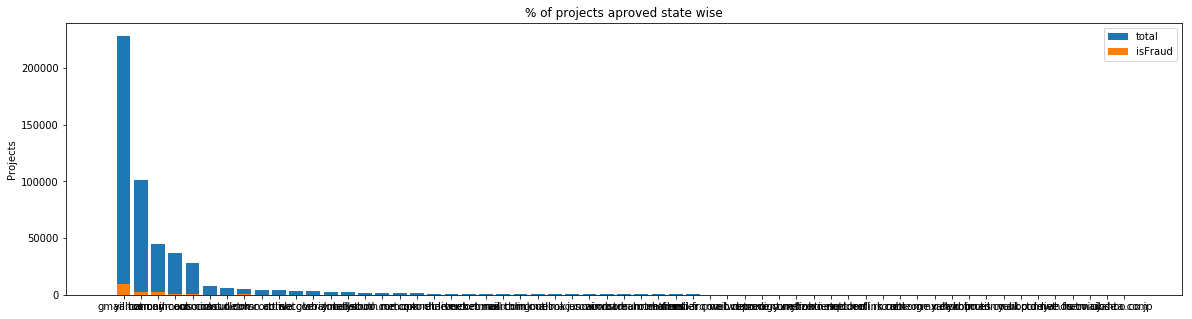

    P_emaildomain  isFraud   total       Avg
16      gmail.com     9943  228355  0.043542
53      yahoo.com     2297  100934  0.022757
19    hotmail.com     2396   45250  0.052950
1   anonymous.com      859   36998  0.023217
2         aol.com      617   28289  0.021811
       P_emaildomain  isFraud  total  Avg
27           live.fr        0     56  0.0
52       yahoo.co.uk        0     49  0.0
20        hotmail.de        0     43  0.0
45  servicios-ta.com        0     35  0.0
51       yahoo.co.jp        0     32  0.0


In [39]:
univariate_barplots(train_transact_ident, 'P_emaildomain', 'isFraud', False)

* mostly used email domain from here we can see that is gmail.com, out of which 4% transactions are fraud.
* most number of fraud transactions are seem to use hotmail.com as their email domain.

## Uninvariate Analysis R_emaildomain

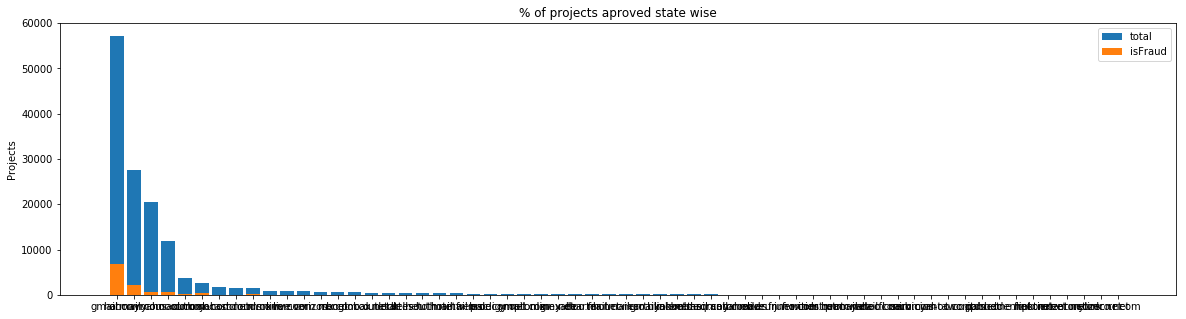

    R_emaildomain  isFraud  total       Avg
16      gmail.com     6811  57147  0.119184
19    hotmail.com     2140  27509  0.077793
1   anonymous.com      598  20529  0.029130
54      yahoo.com      610  11842  0.051512
2         aol.com      129   3701  0.034855
      R_emaildomain  isFraud  total       Avg
14  frontiernet.net        0     14  0.000000
32      netzero.com        0     14  0.000000
6   centurylink.net        0     12  0.000000
33      netzero.net        2      9  0.222222
44        sc.rr.com        0      8  0.000000


In [40]:
univariate_barplots(train_transact_ident, 'R_emaildomain', 'isFraud', False)

## Univariate Analysis M1

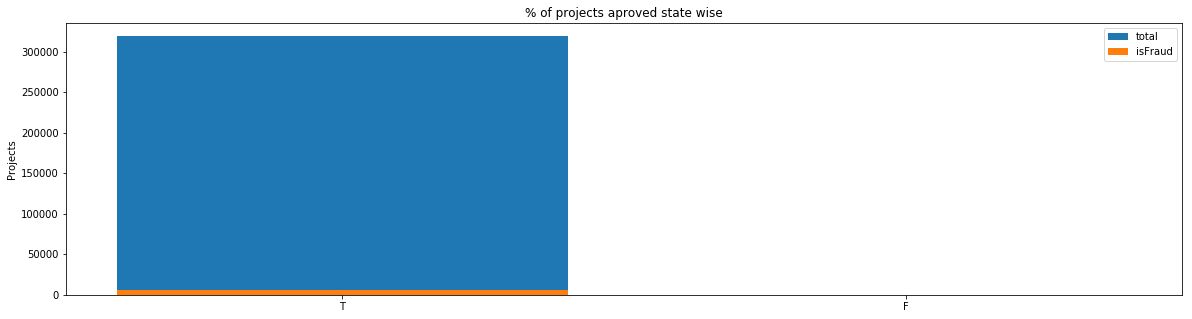

  M1  isFraud   total       Avg
1  T     6342  319415  0.019855
0  F        0      25  0.000000
  M1  isFraud   total       Avg
1  T     6342  319415  0.019855
0  F        0      25  0.000000


In [42]:
univariate_barplots(train_transact_ident, 'M1', 'isFraud', False)

## Univariate Analysis M2

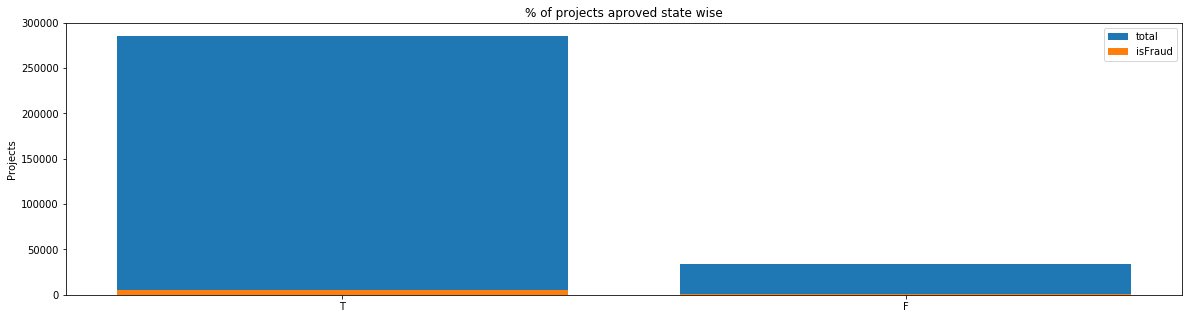

  M2  isFraud   total       Avg
1  T     5158  285468  0.018069
0  F     1184   33972  0.034852
  M2  isFraud   total       Avg
1  T     5158  285468  0.018069
0  F     1184   33972  0.034852


In [43]:
univariate_barplots(train_transact_ident, 'M2', 'isFraud', False)

## Univariate Analysis M3

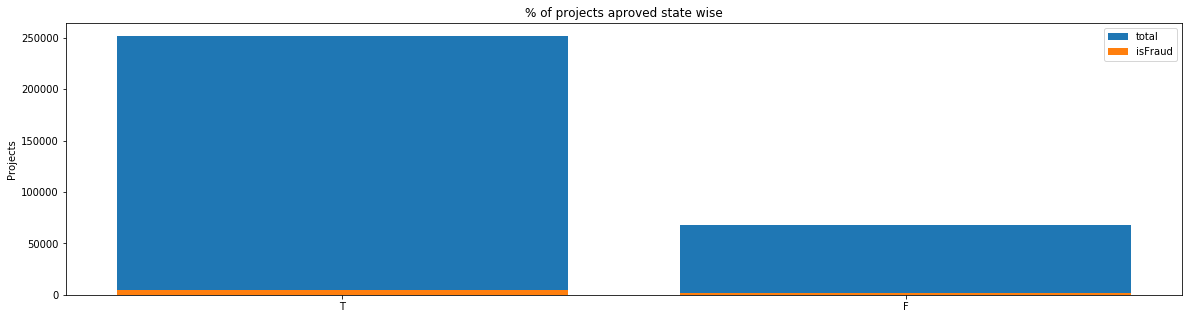

  M3  isFraud   total       Avg
1  T     4293  251731  0.017054
0  F     2049   67709  0.030262
  M3  isFraud   total       Avg
1  T     4293  251731  0.017054
0  F     2049   67709  0.030262


In [44]:
univariate_barplots(train_transact_ident, 'M3', 'isFraud', False)

## Univariate Analysis M4

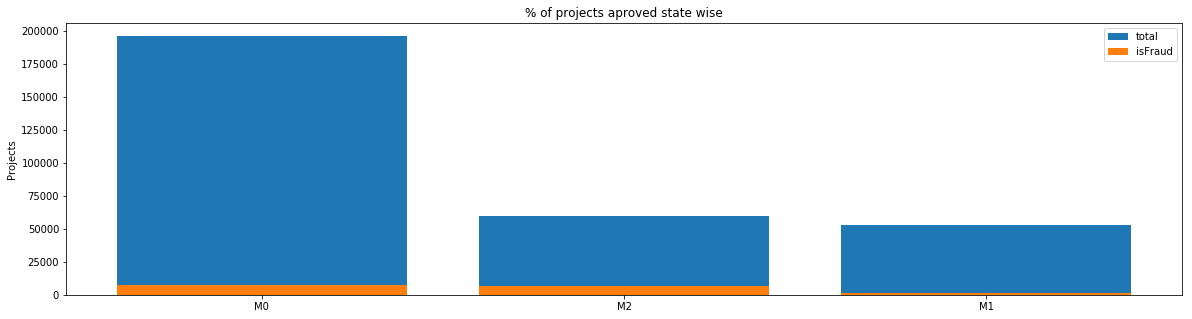

   M4  isFraud   total       Avg
0  M0     7198  196405  0.036649
2  M2     6809   59865  0.113739
1  M1     1429   52826  0.027051
   M4  isFraud   total       Avg
0  M0     7198  196405  0.036649
2  M2     6809   59865  0.113739
1  M1     1429   52826  0.027051


In [45]:
univariate_barplots(train_transact_ident, 'M4', 'isFraud', False) 

## Univariate Analysis M5

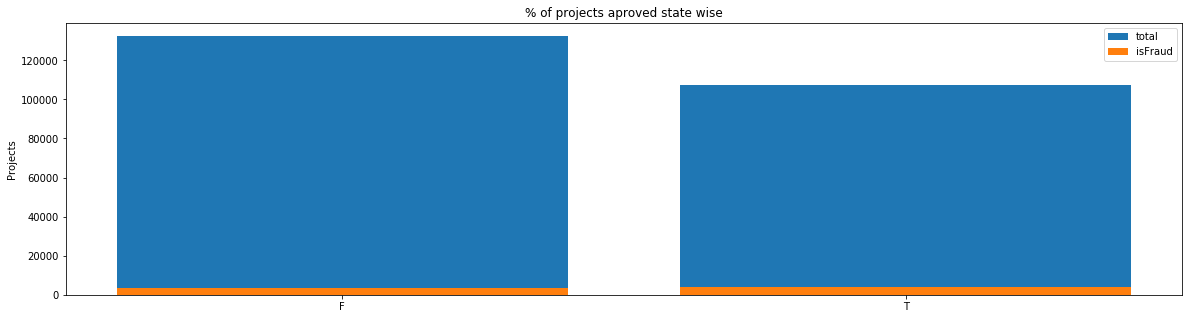

  M5  isFraud   total       Avg
0  F     3514  132491  0.026523
1  T     4055  107567  0.037697
  M5  isFraud   total       Avg
0  F     3514  132491  0.026523
1  T     4055  107567  0.037697


In [46]:
univariate_barplots(train_transact_ident, 'M5', 'isFraud', False)

## Univariate Analysis M6

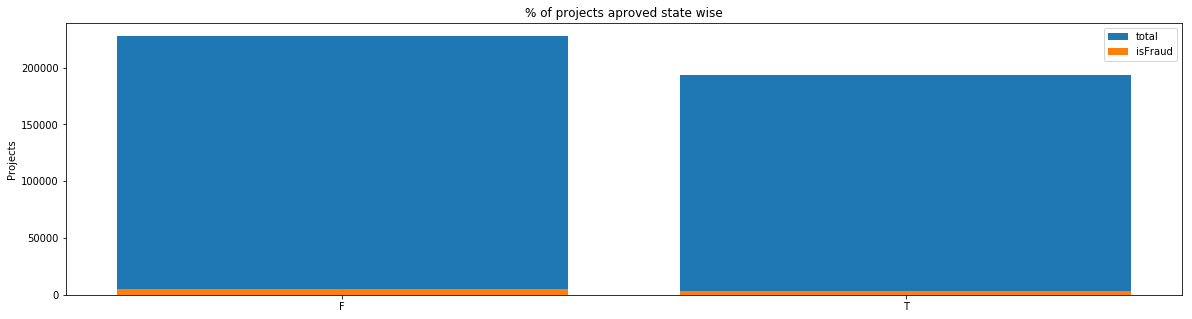

  M6  isFraud   total       Avg
0  F     5397  227856  0.023686
1  T     3295  193324  0.017044
  M6  isFraud   total       Avg
0  F     5397  227856  0.023686
1  T     3295  193324  0.017044


In [47]:
univariate_barplots(train_transact_ident, 'M6', 'isFraud', False)

## Univariate Analysis M7

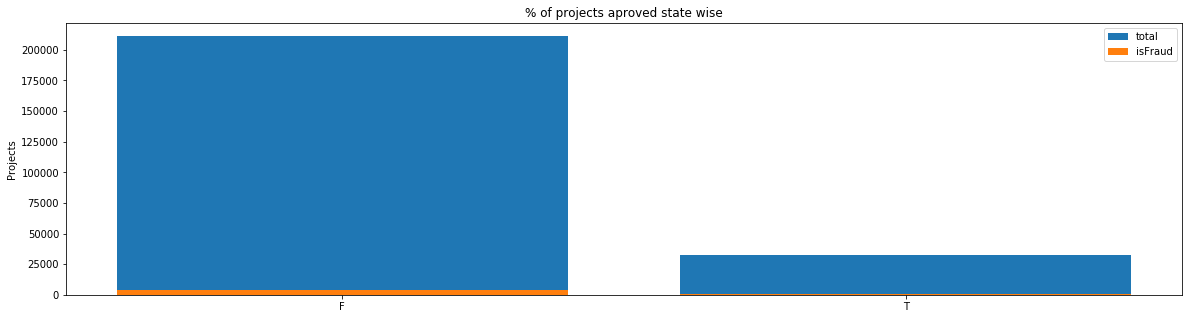

  M7  isFraud   total       Avg
0  F     4089  211374  0.019345
1  T      728   32901  0.022127
  M7  isFraud   total       Avg
0  F     4089  211374  0.019345
1  T      728   32901  0.022127


In [48]:
univariate_barplots(train_transact_ident, 'M7', 'isFraud', False)

## Univariate Analysis M8

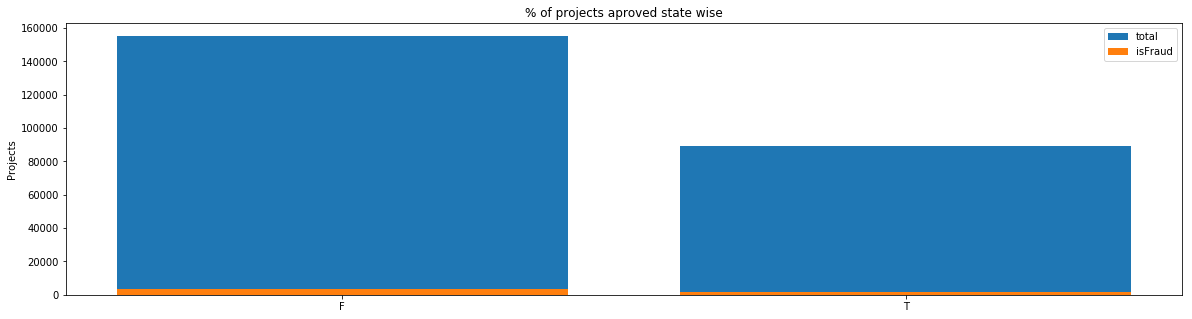

  M8  isFraud   total       Avg
0  F     3373  155251  0.021726
1  T     1444   89037  0.016218
  M8  isFraud   total       Avg
0  F     3373  155251  0.021726
1  T     1444   89037  0.016218


In [49]:
univariate_barplots(train_transact_ident, 'M8', 'isFraud', False)

## Univariate Analysis M9

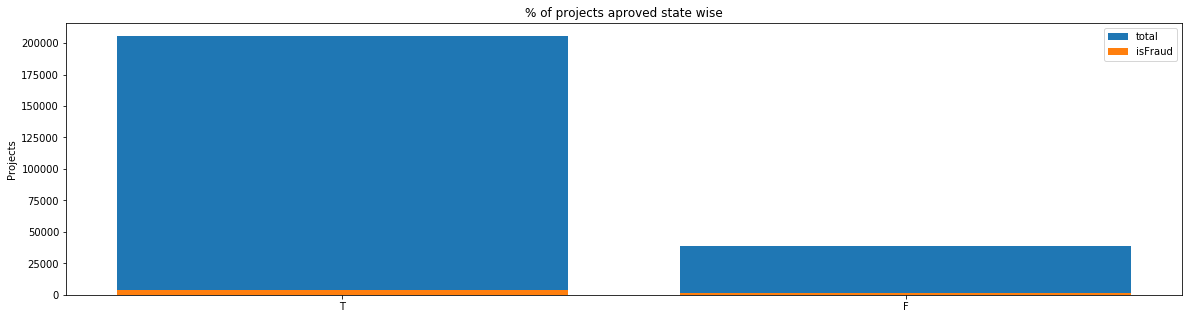

  M9  isFraud   total       Avg
1  T     3658  205656  0.017787
0  F     1159   38632  0.030001
  M9  isFraud   total       Avg
1  T     3658  205656  0.017787
0  F     1159   38632  0.030001


In [50]:
univariate_barplots(train_transact_ident, 'M9', 'isFraud', False)

## Univariate Analysis V1

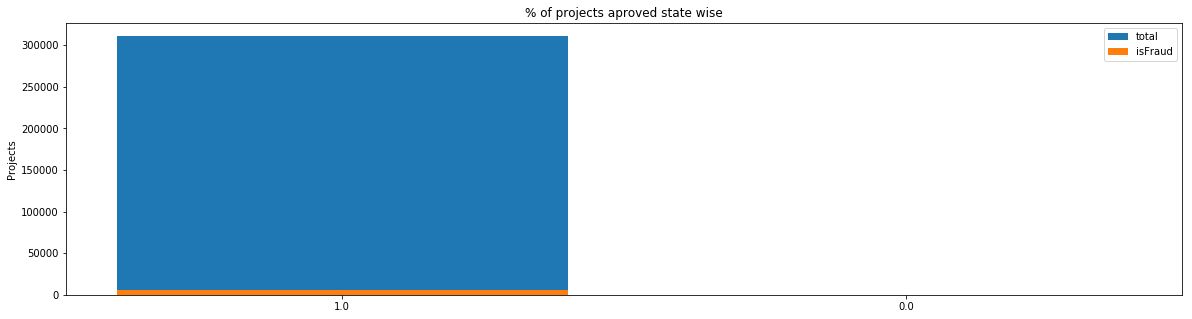

    V1  isFraud   total       Avg
1  1.0     6106  311236  0.019619
0  0.0        0      17  0.000000
    V1  isFraud   total       Avg
1  1.0     6106  311236  0.019619
0  0.0        0      17  0.000000


In [51]:
univariate_barplots(train_transact_ident, 'V1', 'isFraud', False)

## Univariate Analysis V2

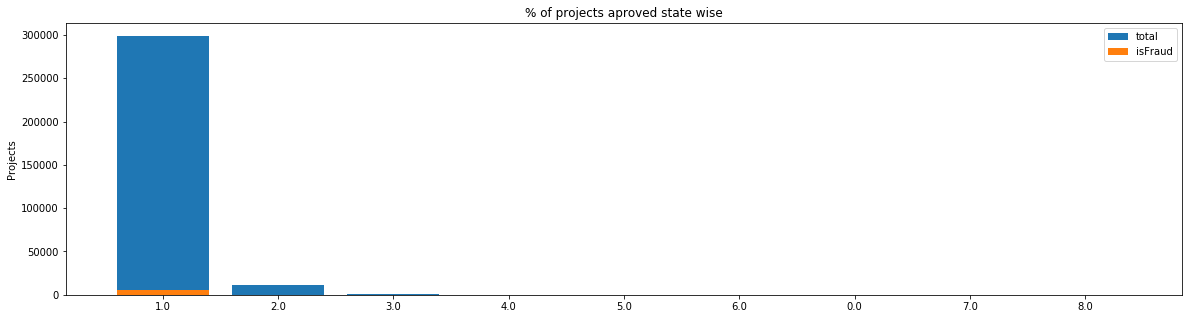

    V2  isFraud   total       Avg
1  1.0     5717  298894  0.019127
2  2.0      330   10926  0.030203
3  3.0       44    1181  0.037257
4  4.0        5     163  0.030675
5  5.0        1      36  0.027778
    V2  isFraud  total       Avg
5  5.0        1     36  0.027778
6  6.0        9     30  0.300000
0  0.0        0     20  0.000000
7  7.0        0      2  0.000000
8  8.0        0      1  0.000000


In [52]:
univariate_barplots(train_transact_ident, 'V2', 'isFraud', False)

## Univariate Analysis V3

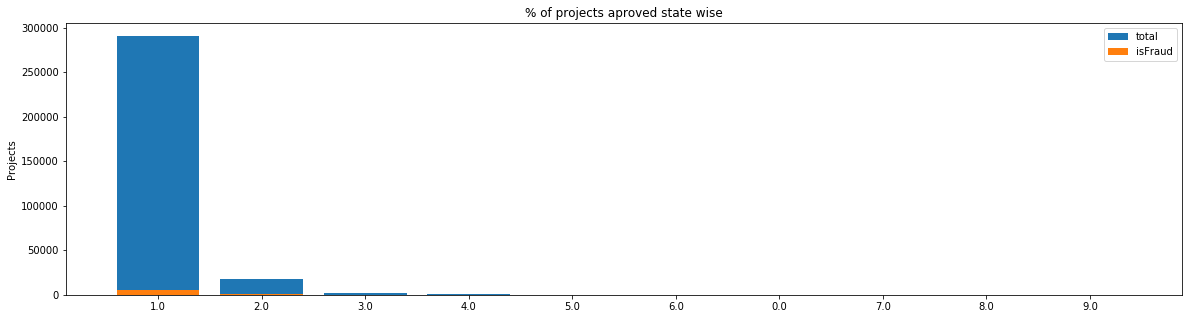

    V3  isFraud   total       Avg
1  1.0     5249  290583  0.018064
2  2.0      631   17763  0.035523
3  3.0      182    2335  0.077944
4  4.0       25     403  0.062035
5  5.0       10      93  0.107527
    V3  isFraud  total       Avg
6  6.0        5     34  0.147059
0  0.0        0     20  0.000000
7  7.0        4     18  0.222222
8  8.0        0      3  0.000000
9  9.0        0      1  0.000000


In [53]:
univariate_barplots(train_transact_ident, 'V3', 'isFraud', False)

## Univariate Analysis V4

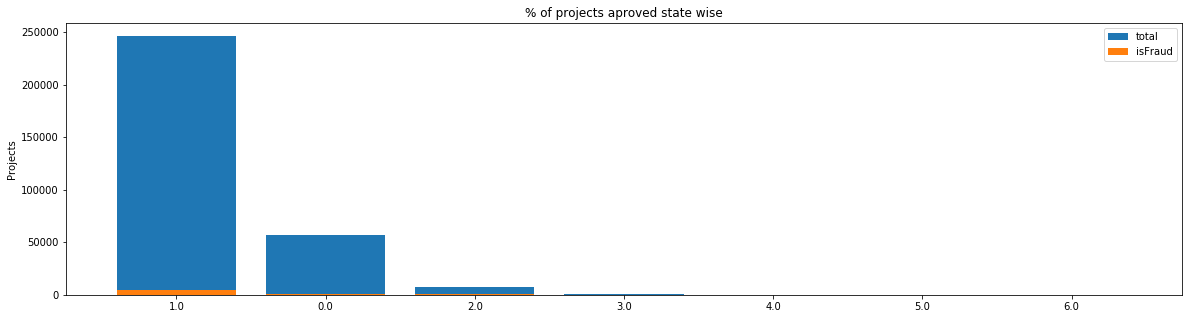

    V4  isFraud   total       Avg
1  1.0     4620  246500  0.018742
0  0.0     1113   56687  0.019634
2  2.0      343    7385  0.046445
3  3.0       18     564  0.031915
4  4.0       12      88  0.136364
    V4  isFraud  total       Avg
2  2.0      343   7385  0.046445
3  3.0       18    564  0.031915
4  4.0       12     88  0.136364
5  5.0        0     26  0.000000
6  6.0        0      3  0.000000


In [54]:
univariate_barplots(train_transact_ident, 'V4', 'isFraud', False)

## Univariate Analysis V33

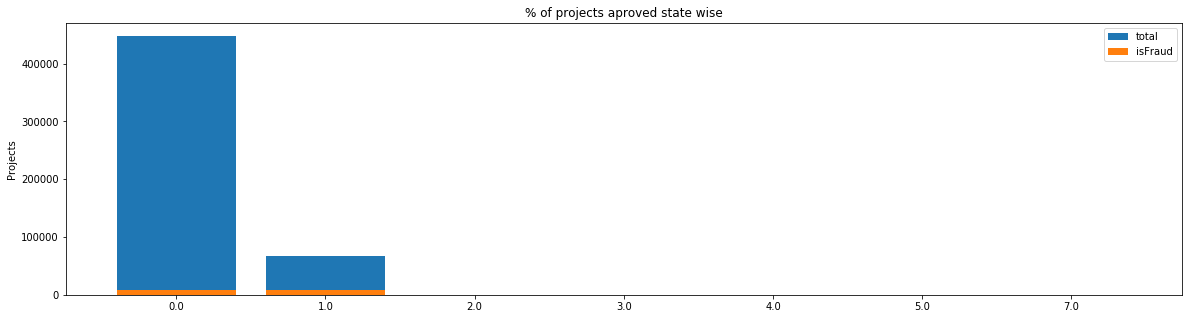

   V33  isFraud   total       Avg
0  0.0     9000  447769  0.020100
1  1.0     7672   66267  0.115774
2  2.0       79     338  0.233728
3  3.0       23      82  0.280488
4  4.0        1       9  0.111111
   V33  isFraud  total       Avg
2  2.0       79    338  0.233728
3  3.0       23     82  0.280488
4  4.0        1      9  0.111111
5  5.0        1      1  1.000000
6  7.0        0      1  0.000000


In [32]:
univariate_barplots(train_transact_ident, 'V33', 'isFraud', False)

### Identity features

## Univariate Analysis DeviceType

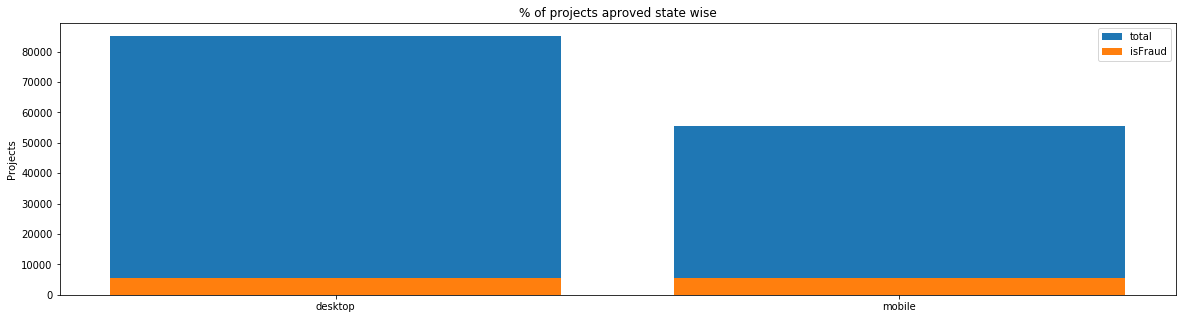

  DeviceType  isFraud  total       Avg
0    desktop     5554  85165  0.065215
1     mobile     5657  55645  0.101662
  DeviceType  isFraud  total       Avg
0    desktop     5554  85165  0.065215
1     mobile     5657  55645  0.101662


In [39]:
univariate_barplots(train_transact_ident, 'DeviceType', 'isFraud', False)

### Here we can observe that more number of fraud transactions are recorded if you are using mobile devices as compared as on desktop.

## Univariate Analysis id_31

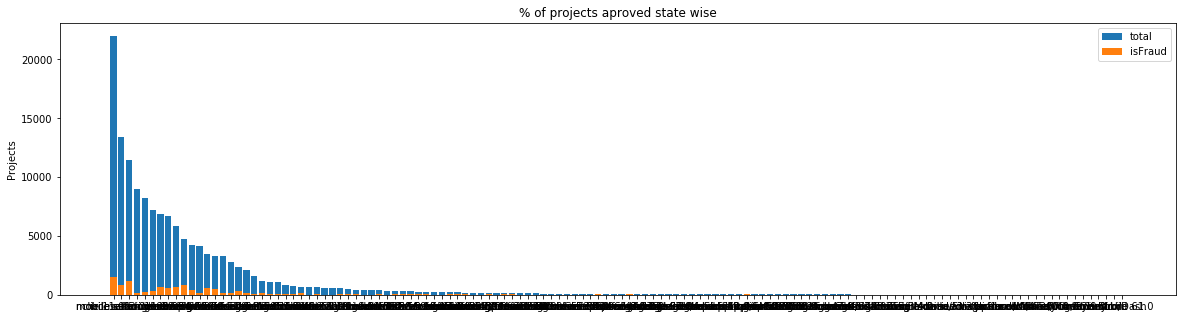

                     id_31  isFraud  total       Avg
47             chrome 63.0     1503  22000  0.068318
98      mobile safari 11.0      842  13423  0.062728
101  mobile safari generic     1146  11474  0.099878
91     ie 11.0 for desktop      175   9030  0.019380
116         safari generic      205   8195  0.025015
                  id_31  isFraud  total  Avg
1                Cherry        0      1  0.0
66             cyberfox        0      1  0.0
85  firefox mobile 61.0        0      1  0.0
93                 iron        0      1  0.0
0              BLU/Dash        0      1  0.0


In [16]:
univariate_barplots(train_transact_ident, 'id_31', 'isFraud', False)

### So this shows chrome and safari browsers are not so secure browsers as most number of frauds are there while using chrome and safari browsers
### firefox is more secure browser

## Univariate Analysis DeviceInfo

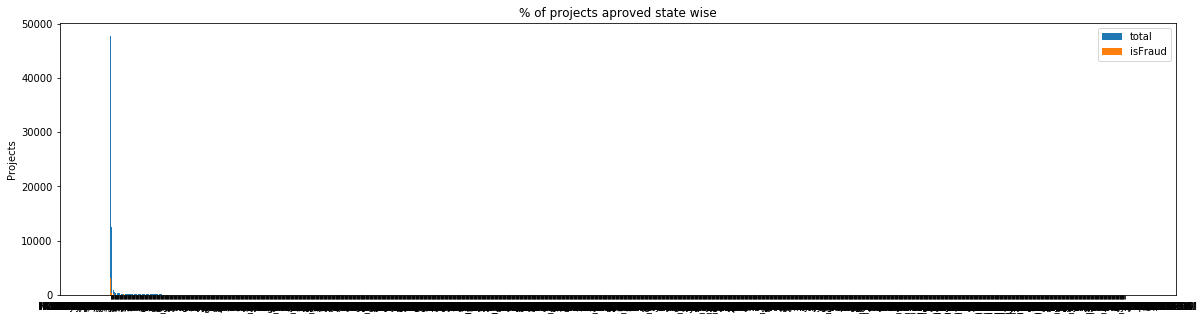

       DeviceInfo  isFraud  total       Avg
1598      Windows     3121  47722  0.065400
1727   iOS Device     1240  19782  0.062683
723         MacOS      278  12573  0.022111
1552  Trident/7.0       96   7440  0.012903
1743      rv:11.0       76   1901  0.039979
          DeviceInfo  isFraud  total  Avg
889         QwestIE8        0      1  0.0
892            R8106        0      1  0.0
1              0PJA2        0      1  0.0
899       RCT6K03W13        0      1  0.0
1785  xs-Z47b7VqTMxs        0      1  0.0


In [40]:
univariate_barplots(train_transact_ident, 'DeviceInfo', 'isFraud', False)

### Windows and iOS devices are more prone to fraud transactions as compared to linux and unix devices

# Model

In [15]:
train_transact_ident.shape

(590540, 434)

In [13]:
test_transact_ident.shape

(506691, 433)

In [17]:
x_train.shape

(590540, 433)

In [16]:
x_train = train_transact_ident[train_transact_ident['isFraud'].notnull()]
x_test = test_transact_ident
y_train = x_train.pop('isFraud')
del train_transact_ident

In [20]:
drop_lst = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

In [21]:
x_train = x_train.drop(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'] , axis=1)


In [22]:
x_test = x_test.drop(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo'], axis=1)

In [23]:
print(x_train.shape)
print(x_test.shape)

(590540, 402)
(506691, 402)


In [21]:
import lightgbm as lgb

In [ ]:


params={'learning_rate': 0.04,
        'feature_fraction': 0.6
        'num_leaves': 64,
        'metric':'auc',
        'objective':'binary',
        'random_state':42,
        'num_threads': -1,
        'bagging_fraction': 1,
        'verbose': 1,
       }

oof_preds = np.zeros(x_train.shape[0])
sub_preds = np.zeros(x_test.shape[0])


skf = StratifiedKFold(n_splits=6, random_state=42)
for train_index, test_index in skf.split(x_train, y_train):
    clf = lgb.LGBMClassifier(**params, n_estimators=3000)
    clf.fit(x_train.iloc[train_index], y_train.iloc[train_index], 
            eval_set=[(x_train.iloc[test_index], y_train.iloc[test_index])], verbose=500) #, early_stopping_rounds=100
    oof_preds[test_index] = clf.predict_proba(x_train.iloc[test_index])[:,1]
    sub_preds += clf.predict_proba(x_test)[:,1] / skf.n_splits

_='''
clf = lgb.LGBMClassifier(**params, n_estimators=5000)
clf.fit(X_train, Y_train, verbose=100)
oof_preds = clf.predict_proba(X_train, num_iteration=clf.best_iteration_)[:,1]
sub_preds = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:,1]
'''

[500]	valid_0's auc: 0.86869
[1000]	valid_0's auc: 0.860024
[1500]	valid_0's auc: 0.855093
[2000]	valid_0's auc: 0.854035
[2500]	valid_0's auc: 0.849607
[3000]	valid_0's auc: 0.847196
